# Evaluating Pedestrian Detections

This notebook provides an end-to-end example of evaluating and comparing object detection models. It demonstrates valor's ability to use business logic to define metadata, by which metrics can stratified/filtered.


We will work through a self-driving car example, where we evaluate model performance on detecting persons in and out of the road. For the dataset we will use Berkeley Deep Drive (https://bdd-data.berkeley.edu/) and we will evaluate against some pretrained torchvision detection models (https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).

*Note: This notebook assumes that the valor service is running on http://localhost:8000. See https://striveworks.github.io/valor/getting_started/ for how set up the valor service. To connect to a different instance of Valor, change the line `connect("http://localhost:8000")` in cell 5 accordingly.*

In [1]:
import json
import os
from pathlib import Path

import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

from valor.enums import TaskType
from valor import Annotation, Datum, Dataset, Model, GroundTruth, Label, Client, Prediction, viz, connect
from valor.schemas import Box, Raster

In [2]:
# make sure the BDD files are in these relative locations (or change the paths below)
imgs_path = Path("bdd100k/images/10k/val/")
masks_path = Path("bdd100k/labels/pan_seg/bitmasks/val/")

## Helper methods

Below we define some helper functions for working with the BDD dataset. See the official BDD documentation for more info: https://doc.bdd100k.com/format.html#segmentation-formats.

In [3]:
def load_image(fname: str) -> Image.Image:
    return Image.open(imgs_path / fname)


def load_mask_array(fname: str) -> np.ndarray:
    """ Takes in the filename of an image and returns the mask array.
    this is an integer array of shape [H, W, 4] that encodes the classes and instance
    ids 
    """
    return np.array(Image.open(masks_path / (fname[:-3] + "png")))


def get_road_binary_mask(mask: np.ndarray) -> np.ndarray:
    """ Returns a binary array of shape [H, W] of which pixels correspond to roads
    """
    # the first channel of the mask is the category, which is 7 for roads
    return mask[:, :, 0] == 7


def get_person_instances_mask(mask: np.ndarray) -> np.ndarray:
    """ Returns an integer array of shape [H, W] where the non-zero values are pixels
    corresponding to people and the value is the instance id (unique to each different person
    in the image)
    """
    # category int for person is 31, and the last channel corresponds to instance id
    return (mask[:, :, 0] == 31) * mask[:, :, 3]


def person_is_in_road(person_bbox: Box, road_binary_mask: np.ndarray) -> bool:
    """ Determines if a person is in a road or not by checking if there are road
    pixels immediately to the left and immediately to the right of the bottom of the
    bounding box
    """
    # determine if person and road intersect sufficiently much
    road_on_left, road_on_right = False, False
    btm_y = min(int(person_bbox.ymax), road_binary_mask.shape[0] - 1)
    for offset in range(1, 5):
        if road_binary_mask[btm_y, max(int(person_bbox.xmin) - offset, 0)]:
            road_on_left = True
        if road_binary_mask[btm_y, min(int(person_bbox.xmax) + offset, road_binary_mask.shape[1] - 1)]:
            road_on_right = True

    return road_on_left and road_on_right


def get_person_bboxes(person_instances_mask: np.ndarray) -> list[BoundingBox]:
    """ From the integer mask of person instance ids, return a list of
    `Box` objects, representing the bounding boxes for each person.
    """
    boxes = []
    for instance_id in np.unique(person_instances_mask):
        if instance_id == 0:
            continue
        person_mask = person_instances_mask == instance_id
        ys, xs = np.where(person_mask)
        ymin, xmin, ymax, xmax = min(ys), min(xs), max(ys), max(xs)

        if ymin != ymax and xmin != xmax:
            boxes.append(BoundingBox.from_extrema(xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax))
    
    return boxes

## Example image

Here we show an example image from the dataset, and draw bounding boxes around each person. We color the box yellow if the person is in the street (according to our definition) and green if it is not.

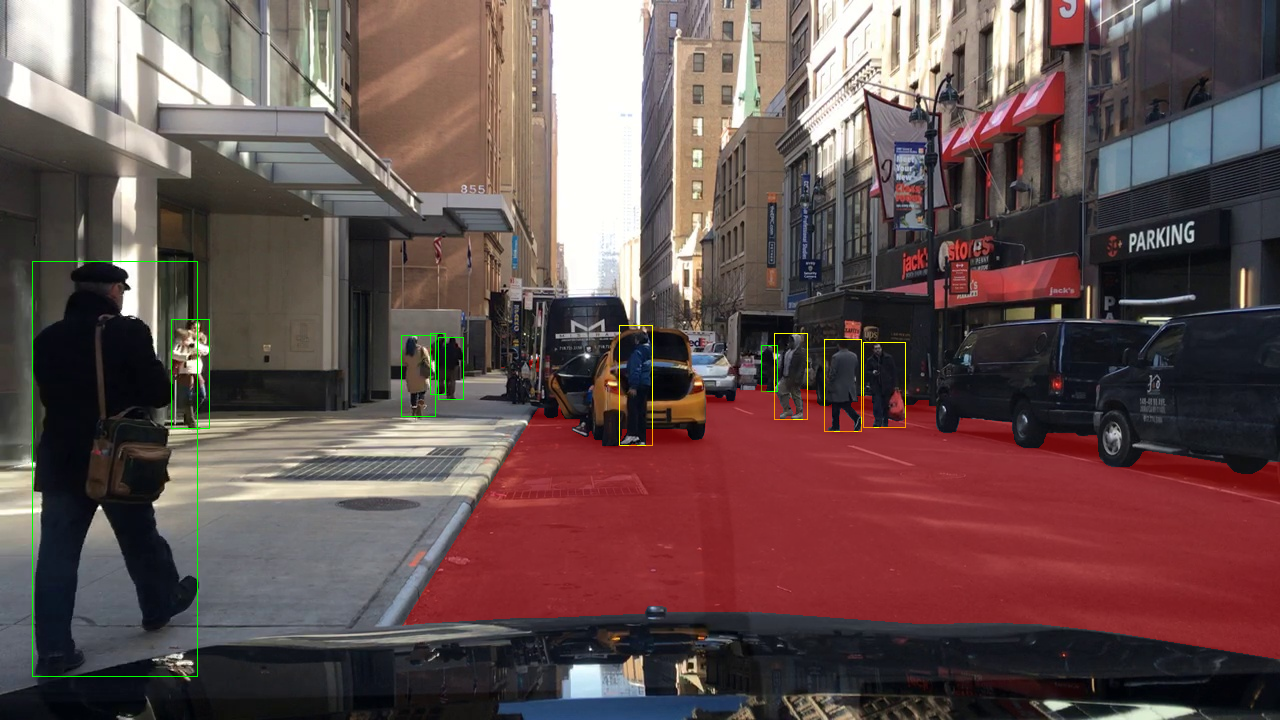

In [4]:
fname = "9b970e47-51dde695.jpg"

img = load_image(fname)
mask = load_mask_array(fname)

road_binary_mask = get_road_binary_mask(mask)
person_instances_mask = get_person_instances_mask(mask)

person_bboxes = get_person_bboxes(person_instances_mask) 
for person_bbox in person_bboxes:
    if person_is_in_road(person_bbox, road_binary_mask):
        color = (255, 255, 0)
    else:
        color = (0, 255, 0)

    # img = person_bbox.draw_on_image(img, color=color)
    img = viz.draw_bounding_box_on_image(person_bbox, img=img, color=color)

road_raster = Raster.from_numpy(road_binary_mask)
img = viz.draw_raster_on_image(road_raster, img)

display(img)

## Create the valor dataset

In [5]:
# connect to the Valor API
connect("http://0.0.0.0:8000")
client = Client()


Successfully connected to host at http://localhost:8000/


In [6]:
dset = Dataset.create(name="bdd10k-people-in-roads")

Now we itereate through the images in the dataset and create ground truth. We store the information of whether or not a bounding box is in the road as *metadata*, in the `"in_road"`. This demonstrates valor's ability to incorporate custom defined business logic to evaluate against (the besoke definition of `"in_road"`). 

In [7]:
for fname in tqdm(os.listdir(imgs_path)):
    datum = Datum(uid=fname)
    
    mask = load_mask_array(fname)
    
    road_binary_mask = get_road_binary_mask(mask)
    person_instances_mask = get_person_instances_mask(mask)
    
    person_bboxes = get_person_bboxes(person_instances_mask)
    
    if len(person_bboxes) == 0:
        continue
    
    annotations = [
        Annotation(
            task_type=TaskType.OBJECT_DETECTION,
            bounding_box=person_bbox,
            labels=[Label(key="class", value="person")],
            metadata={"in_road": person_is_in_road(person_bbox, road_binary_mask)}
        )
        for person_bbox in person_bboxes
    ]
    
    gt = GroundTruth(datum=datum, annotations=annotations)
    dset.add_groundtruth(gt)

dset.finalize()

  0%|          | 0/1000 [00:00<?, ?it/s]

<Response [200]>

Get a quick summary of the number of images, bounding boxes, and metadata uploaded

In [8]:
dset.get_summary()

DatasetSummary(name='bdd10k-people-in-roads', num_datums=379, num_annotations=1171, num_bounding_boxes=1171, num_polygons=0, num_groundtruth_multipolygons=0, num_rasters=0, task_types=[<TaskType.OBJECT_DETECTION: 'object-detection'>], labels=[<valor.coretypes.Label object at 0x116c30f70>], datum_metadata=[], annotation_metadata=[{'in_road': False}, {'in_road': True}])

## Run inference

In [9]:
import pandas as pd
import torch
from torchvision.transforms.functional import to_tensor
from torchvision.models.detection import (
    retinanet_resnet50_fpn_v2,
    RetinaNet_ResNet50_FPN_V2_Weights,
    fcos_resnet50_fpn,
    FCOS_ResNet50_FPN_Weights,
    fasterrcnn_mobilenet_v3_large_fpn
)

In [10]:
# set the device to GPU if available, otherwise cpu
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

retinanet = retinanet_resnet50_fpn_v2(weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1).to(device).eval()
fcos = fcos_resnet50_fpn(weights=FCOS_ResNet50_FPN_Weights.COCO_V1).to(device).eval()

In [11]:
@torch.no_grad
def detect_people_on_image(net: torch.nn.Module, fname: str, score_thres: float=0.2) -> tuple[list[Box], list[float]]:
    """ Method to run inference on an image in the BDD dataset, and return output in valor's bounding box format.
    
    Parameters
    ----------
    net
        the torchvision detection model to use
    name
        filename of image to run inference on
    score_thres
        score threshold to determine if a detection is kept
    
    Returns
    -------
    tuple
        first element of the tuple is a list of all predicted bounding boxes of detected people, and the
        second element is a list of the confidence scores of the detections.
    """
    img = load_image(fname)
    img_tensor = to_tensor(img).unsqueeze(0).to(device)
    out = net(img_tensor)[0]
    
    score_mask = out["scores"] > score_thres
    # filter out only person detections (those have label 1)
    label_mask = out["labels"] == 1
    
    bounding_boxes = [
        box.from_extrema(xmin=box[0], ymin=box[1], xmax=box[2], ymax=box[3])
        for box in out["boxes"][score_mask & label_mask].tolist()
    ]
    scores = out["scores"][score_mask & label_mask].tolist()
    
    return bounding_boxes, scores

## Example inference

Here we show an example inference, with the bounding box detections drawn on the image

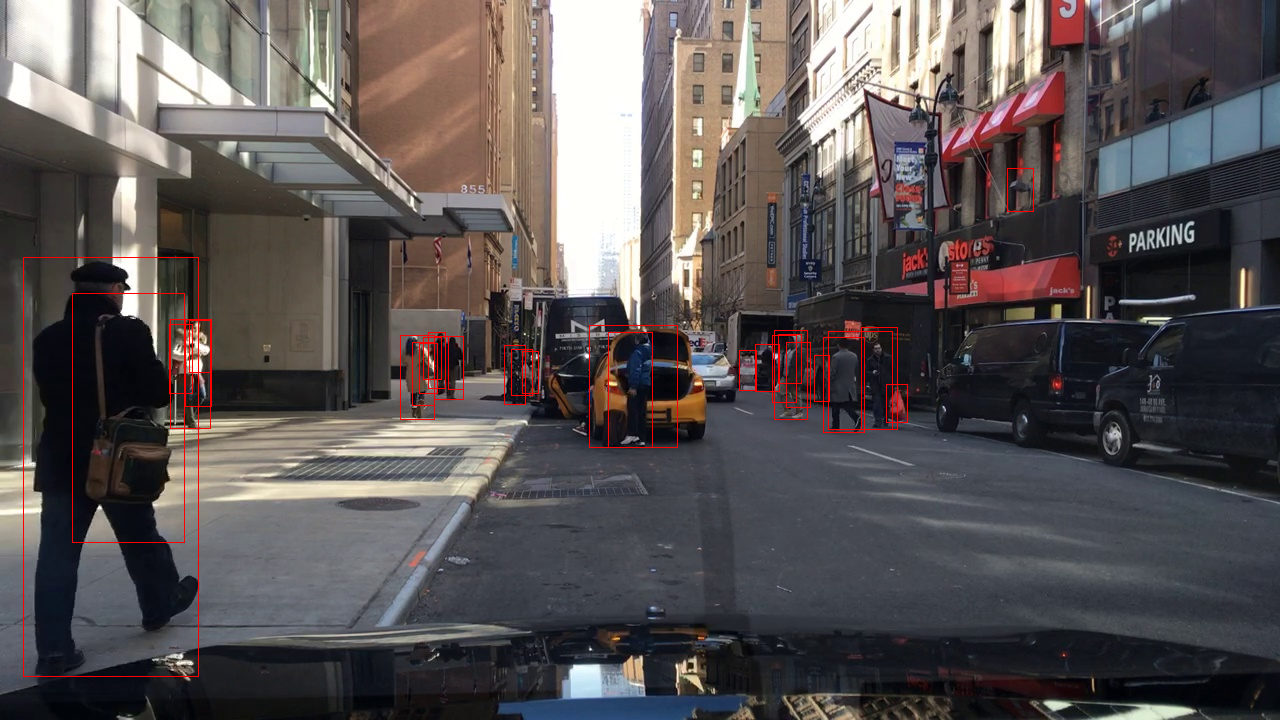

In [12]:
fname = "9b970e47-51dde695.jpg"
person_bboxes, _ = detect_people_on_image(retinanet, fname)

img = load_image(fname)
for person_bbox in person_bboxes:
    img = viz.draw_bounding_box_on_image(person_bbox, img)

display(img)

## Create the valor models, add predictions, and evaluate

Below we define methods for adding inferences to valor and then evaluating the model

In [13]:
def add_predictions(valor_model: Model, torch_model: torch.nn.Module) -> None:
    """ This method computes inferences of a torch model on the BDD dataset and then uploads the results to valor. This code
    is very similar to the main block of the `Create the valor dataset` section
    
    Parameters
    ----------
    valor_model
        the valor model object to associate the inferences with
    torch_model
        the torchvision detection network
    """
    for datum in tqdm(dset.get_datums()):
        fname = datum.uid

        mask = load_mask_array(fname)

        road_binary_mask = get_road_binary_mask(mask)

        person_bboxes, scores = detect_people_on_image(torch_model, datum.uid)

        annotations = [
            Annotation(
                task_type=TaskType.OBJECT_DETECTION,
                bounding_box=person_bbox,
                labels=[Label(key="class", value="person", score=score)],
                metadata={"in_road": person_is_in_road(person_bbox, road_binary_mask)}
            )
            for person_bbox, score in zip(person_bboxes, scores)
        ]

        pred = Prediction(datum=datum, annotations=annotations)

        valor_model.add_prediction(dset, pred)
    valor_model.finalize_inferences(dset)


def evaluate(valor_model: Model) -> tuple[pd.DataFrame, pd.DataFrame]:
    """ Carries out the evaluation of the model
    
    Parameters
    ----------
    valor_model
        the valor model object to associate the inferences with
    
    Returns
    -------
    tuple
        first element of the tuple is a pandas dataframe giving the metrics for the overall performance of the model. the second
        is a pandas dataframe that gives the performance of the model just on detection people in roads
    """
    # compute unfiltered evaluation
    reg_eval = valor_model.evaluate_detection(dset)
    reg_eval.wait_for_completion()
    
    # evaluate on just people for which the `"in_road"` metadata field is `True`
    in_road_eval = valor_model.evaluate_detection(dset, filter_by=[Annotation.metadata["in_road"] == True])
    in_road_eval.wait_for_completion()
    
    
    return reg_eval, in_road_eval

Below we evaluate two different models on the dataset (`FCOS Resnet50FPN ` and `Retinanet Resnet50FPN`), both pretrained on coco. We organize the results in a dataframe to carry out model comparison

In [14]:
ap_ave_over_ious = {}

for model_name, net in [("fcos_resnet50_fpn", fcos), ("retinanet_resnet50_fpn_v2", retinanet)]:
    
    model = Model.create(model_name)
    add_predictions(model, net)
    
    reg_eval, in_road_eval = evaluate(model)
    
    reg_df = reg_eval.to_dataframe()
    in_road_df = in_road_eval.to_dataframe()
    
    print(f"Full evaluation reports for {model_name}")
    
    print("\nTotal evaluation")
    print("-----------------")
    print(reg_df)

    print("\n\nEvaluation on people in road")
    print("-----------------------------")
    print(in_road_df)
    
    print("\n\n\n")
    
    ap_ave_over_ious[model_name] = {
        "total": reg_df.loc["APAveragedOverIOUs"].value[reg_eval.id].item(),
        "in_road": in_road_df.loc["APAveragedOverIOUs"].value[in_road_eval.id].item()
    }

  0%|          | 0/379 [00:00<?, ?it/s]

Full evaluation reports for fcos_resnet50_fpn

Total evaluation
-----------------
                                                                                         value
evaluation                                                                                   7
type                parameters                                         label                  
AP                  {"iou": 0.5}                                       class: person  0.511829
                    {"iou": 0.75}                                      class: person  0.297618
APAveragedOverIOUs  {"ious": [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8,... class: person  0.297068
mAP                 {"iou": 0.5}                                       n/a            0.511829
                    {"iou": 0.75}                                      n/a            0.297618
mAPAveragedOverIOUs {"ious": [0.5, 0.55, 0.6, 0.7, 0.65, 0.75, 0.8,... n/a            0.297068


Evaluation on people in road
-----------------------------
  

  0%|          | 0/379 [00:00<?, ?it/s]

/Users/eric/repos/valor/client/valor/coretypes.py:1231: UserWarning: Prediction for datum with uid `8e437e6c-b40fad7d.jpg` contains no annotations.
  warnings.warn(
/Users/eric/repos/valor/client/valor/coretypes.py:1231: UserWarning: Prediction for datum with uid `a2ae40f3-00000000.jpg` contains no annotations.
  warnings.warn(
/Users/eric/repos/valor/client/valor/coretypes.py:1231: UserWarning: Prediction for datum with uid `a91b7555-00001085.jpg` contains no annotations.
  warnings.warn(
/Users/eric/repos/valor/client/valor/coretypes.py:1231: UserWarning: Prediction for datum with uid `a91b7555-00001250.jpg` contains no annotations.
  warnings.warn(
/Users/eric/repos/valor/client/valor/coretypes.py:1231: UserWarning: Prediction for datum with uid `a00d3a96-00000000.jpg` contains no annotations.
  warnings.warn(
/Users/eric/repos/valor/client/valor/coretypes.py:1231: UserWarning: Prediction for datum with uid `8119e56e-00000000.jpg` contains no annotations.
  warnings.warn(
/Users/eri

Full evaluation reports for retinanet_resnet50_fpn_v2

Total evaluation
-----------------
                                                                                         value
evaluation                                                                                   9
type                parameters                                         label                  
AP                  {"iou": 0.5}                                       class: person  0.503219
                    {"iou": 0.75}                                      class: person  0.311630
APAveragedOverIOUs  {"ious": [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8,... class: person  0.294759
mAP                 {"iou": 0.5}                                       n/a            0.503219
                    {"iou": 0.75}                                      n/a            0.311630
mAPAveragedOverIOUs {"ious": [0.5, 0.55, 0.6, 0.7, 0.65, 0.75, 0.8,... n/a            0.294759


Evaluation on people in road
------------------------

We now focus on the aggregate metrics `APAveragedOverIOUs`. From the table below we see that score for detecting people overall is very close between the two models (with a slight advantange to `fcos_resnet50_fpn`). However, if we are more concerned with being able to detect people in roads, then the model `retinanet_resnet50_fpn_v2` is clearly the better choice. 

In [15]:
pd.DataFrame(ap_ave_over_ious)

,fcos_resnet50_fpn,retinanet_resnet50_fpn_v2
total,0.297068,0.294759
in_road,0.390968,0.421248
